# Data Extraction
## Building a dataset for analysis
The goal of this notebook is to build a dataset that we can base our analysis on.

The idea is that if we can have enough data and factors (variables/features), we can actually interpret the probability of a company laying off employees, maybe even predict the size of the layoff.

Also based on this attribution, we can as well predict if a company is stable enough after a wave of layoffs or will it need a deeper cut.

The first data set we use is the layoffs data from layoffs.fyi, we can find it on Kaggle at: https://www.kaggle.com/datasets/swaptr/layoffs-2022

Let's load this dataset and see what details do we still need.

### Exploratoray Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
layoffs = pd.read_csv("layoffs.csv")

In [3]:
layoffs

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Zomato,Gurugram,Food,100.0,0.04,2022-11-19,Series J,India,914.0
1,Carvana,Phoenix,Transportation,1500.0,0.08,2022-11-18,IPO,United States,1600.0
2,Nuro,SF Bay Area,Transportation,300.0,0.20,2022-11-18,Series D,United States,2100.0
3,Kavak,Sao Paulo,Transportation,NaN,NaN,2022-11-18,Series E,Brazil,1600.0
4,Metaplex,Chicago,Crypto,NaN,NaN,2022-11-18,Unknown,United States,NaN
...,...,...,...,...,...,...,...,...,...
1646,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1
1647,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0
1648,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0
1649,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0


Let's see how many entries are missing layoff data

In [4]:
layoffs["total_laid_off"].isna().sum()

476

In [5]:
layoffs["percentage_laid_off"].isna().sum()

546

In [6]:
layoffs[(layoffs["total_laid_off"].isna()) & (layoffs["percentage_laid_off"].isna())].shape[0]

244

What about countries affected?

<AxesSubplot:xlabel='country'>

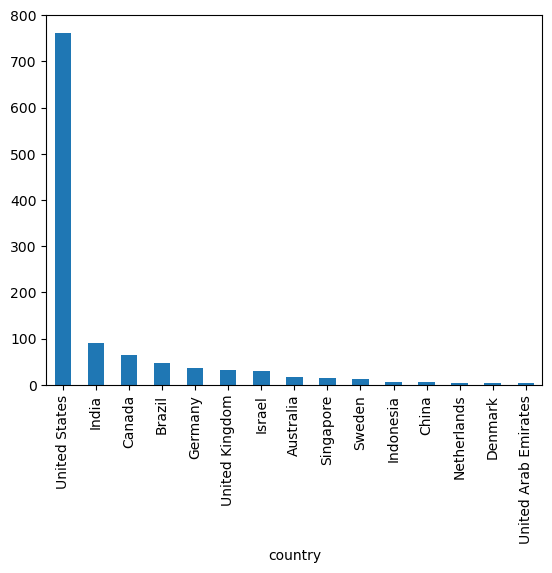

In [7]:
layoffs.groupby("country")["total_laid_off"].count().sort_values(ascending=False).head(n=15).plot(kind="bar")

Looks like a huge proportion of the layoffs happened in the US, let's see how many employees were affected per country

<AxesSubplot:xlabel='country'>

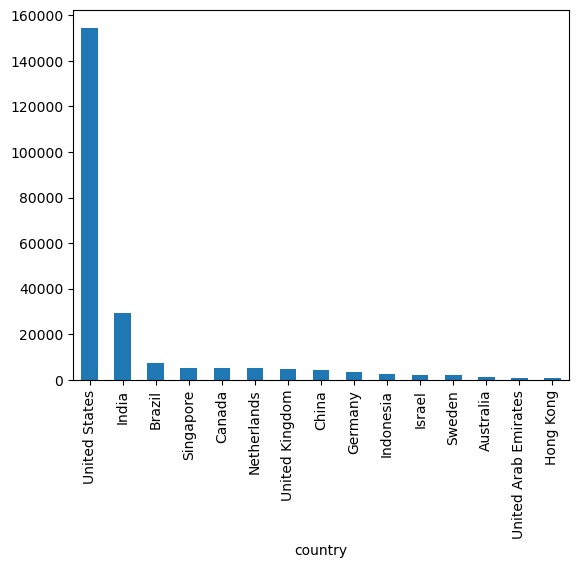

In [8]:
layoffs.groupby("country")["total_laid_off"].sum().sort_values(ascending=False).head(n=15).plot(kind="bar")

How about the industries affected?

<AxesSubplot:xlabel='industry'>

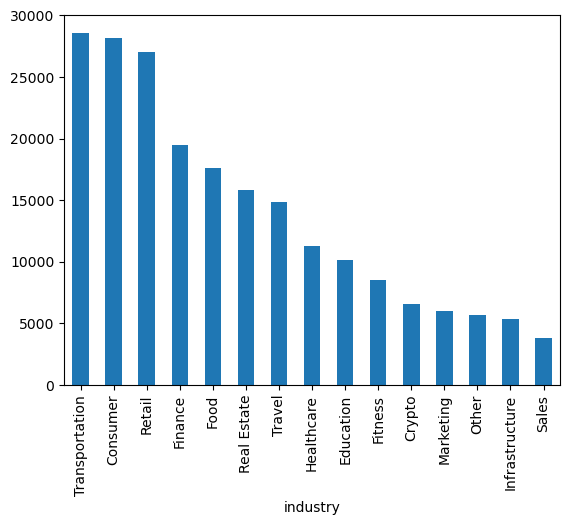

In [9]:
layoffs.groupby("industry")["total_laid_off"].sum().sort_values(ascending=False).head(n=15).plot(kind="bar")

I'm interested in looking at the industries affected per year. I'd expect transporation and travel were hugely impacted in 2019/2020 but as the world started recovering from Covid things were better for them. On the contrary, I'd hypothesis that in 2022 industries like Finance, Crypto, Real Estate, Consumer would be the ones with the biggest hit

<AxesSubplot:title={'center':'Yearly layoffs in various industries world wide'}, xlabel='industry', ylabel='total_laid_off'>

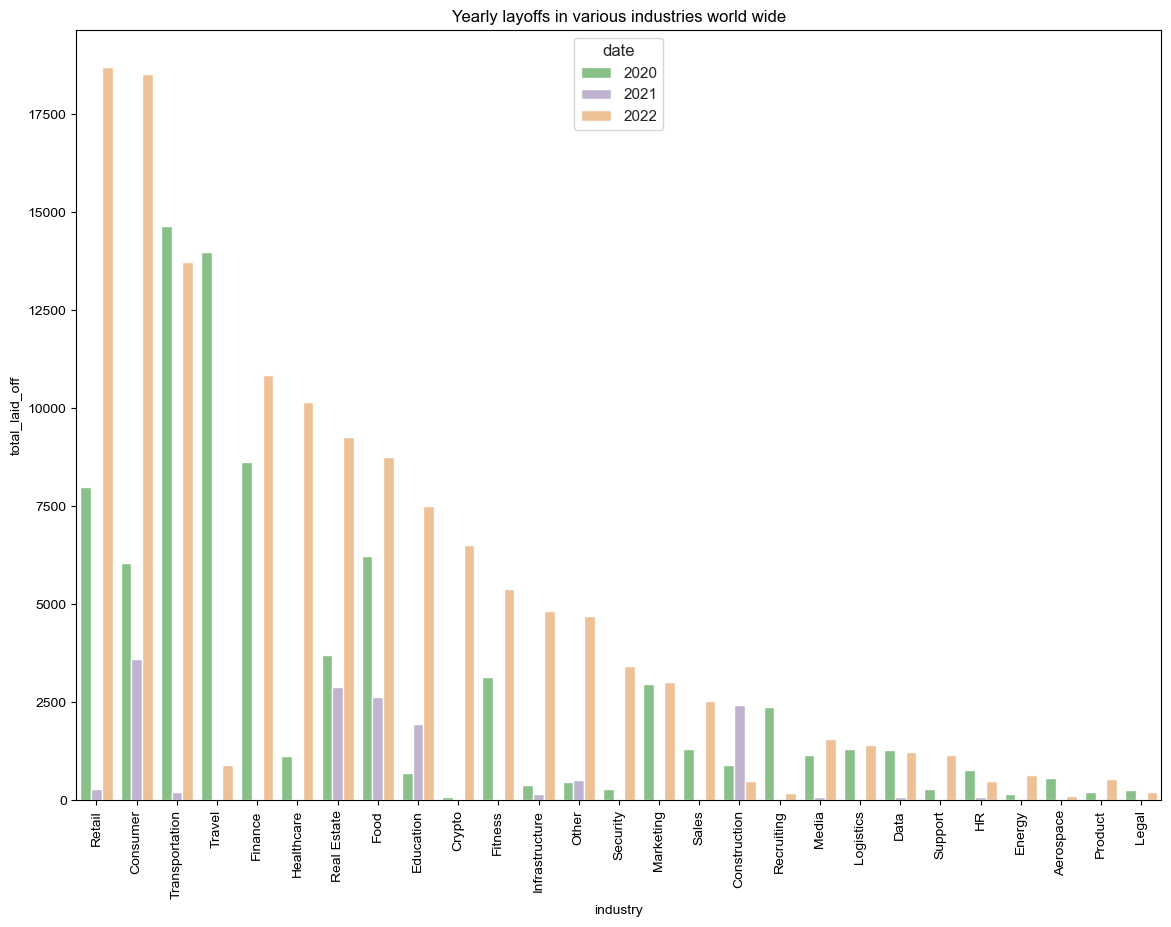

In [10]:
# Courtesy of: https://www.kaggle.com/code/fnmalik2002/layoffs-2022-dataset-eda
layoffs = layoffs.reset_index(drop=True)
layoffs['date'] = pd.to_datetime(layoffs['date'])
layoffs_industry = layoffs.groupby([ layoffs.industry, layoffs.date.dt.year]).sum()
layoffs_industry = layoffs_industry.reset_index()

plt.figure(figsize=(14, 10))
plt.xticks(rotation=90)
plt.title("Yearly layoffs in various industries world wide")
sns.set(style="white", palette="Accent", color_codes=True)

sns.barplot(data=layoffs_industry.sort_values(by=['total_laid_off','date'], ascending=False), x="industry", y="total_laid_off", hue="date")

Maybe the absolute number of layoffs isn't so robust since it's relative to an industry's size.

Let's instead look at the percentage laid off

<AxesSubplot:title={'center':'Yearly percentage layoffs in various industries world wide'}, xlabel='industry', ylabel='percentage_laid_off'>

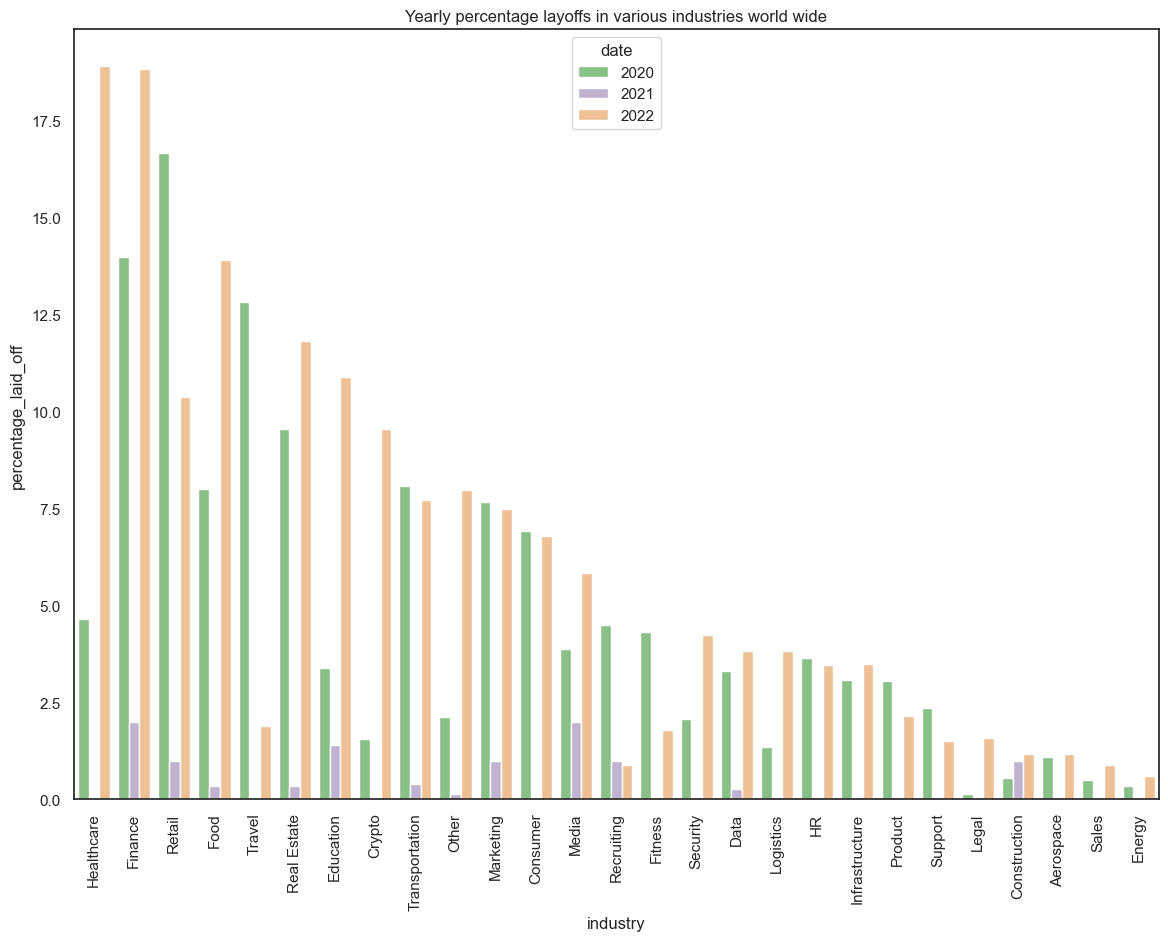

In [11]:
plt.figure(figsize=(14, 10))
plt.xticks(rotation=90)
plt.title("Yearly percentage layoffs in various industries world wide")
sns.set(style="white", palette="Accent", color_codes=True)

sns.barplot(data=layoffs_industry.sort_values(by=['percentage_laid_off','date'], ascending=False), x="industry", y="percentage_laid_off", hue="date")

So far everything looks good, however, we only have data about Layoffs, industry, and size.

If we want to attribute layoffs to a possible economical cause we need to extract more data for each company's economical status

Let's first see how many companies are in the data and out of which how many are public

In [12]:
layoffs["company"].value_counts()

Uber             5
Shopify          4
WeWork           4
Loft             4
Gopuff           4
                ..
Wave             1
OpenSea          1
Cosuno           1
Kiavi            1
Tamara Mellon    1
Name: company, Length: 1385, dtype: int64

In [13]:
layoffs[layoffs["stage"] == "IPO"].shape[0]

229

So out of 1385 companies, 229 are public.

Getting data for public companies is much easier than getting it for startups/private companies.

Let's try to seek our sources

In [14]:
layoffs

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Zomato,Gurugram,Food,100.0,0.04,2022-11-19,Series J,India,914.0
1,Carvana,Phoenix,Transportation,1500.0,0.08,2022-11-18,IPO,United States,1600.0
2,Nuro,SF Bay Area,Transportation,300.0,0.20,2022-11-18,Series D,United States,2100.0
3,Kavak,Sao Paulo,Transportation,NaN,NaN,2022-11-18,Series E,Brazil,1600.0
4,Metaplex,Chicago,Crypto,NaN,NaN,2022-11-18,Unknown,United States,NaN
...,...,...,...,...,...,...,...,...,...
1646,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1
1647,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0
1648,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0
1649,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0


### Public Companies Data

In [208]:
import requests
import time

def get_ticker(company_name):
    user_agent_headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    url = f"https://query2.finance.yahoo.com/v1/finance/search"
    params = {"q": company_name, "lang": "en-US", "region": "US"}
    response = requests.get(url=url, headers=user_agent_headers, params=params)
    data = response.json()
    # A small wait time so the API won't block us
    time.sleep(0.2)
    if len(data["quotes"]) > 0:
        company_code = data['quotes'][0]["symbol"]
        return company_code
    else:
        return None

In [209]:
name2ticker = {name: get_ticker(name) for name in layoffs["company"].values}

In [229]:
len(list(filter(lambda x: name2ticker[x] is not None, list(name2ticker.keys()))))

470

470 is the number of companies that were matched to a public ticker

**Assuming correctness**

This means that we can extract a lot of data for these 470 companies. but there are also some data we can get for private companies

Based on these tickers we can pull a lot of data for these companies, but these aren't our only companies, we still need to pull data for the remaining non public companies.

In [216]:
import yfinance as yf
import tqdm

public_companies_data = []
data_elements_to_keep = {"fullTimeEmployees", "profitMargins", "revenueGrowth", "operatingMargins", "earningsGrowth", "currentRatio", "returnOnAssets", "returnOnEquity", "forwardEps", "shortRatio", "beta", "earningsQuarterlyGrowth", "payoutRatio"}
for company in tqdm.tqdm(name2ticker.keys(), total=len(list(name2ticker.keys()))):
    if name2ticker[company] is None:
        continue
    ticker = yf.Ticker(name2ticker[company])
    try:
        info = ticker.info
    except:
        print(f"Failed retrieving data for {company}")
        continue
    selected_info = {}
    for key in info.keys():
        if key in data_elements_to_keep:
            selected_info[key] = info[key]
    selected_info["company"] = company
    selected_info["ticker"] = name2ticker[company]
    public_companies_data.append(selected_info)

public_companies_df = pd.DataFrame.from_dict(public_companies_data)
public_companies_df.to_excel("public_companies.xlsx", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1385/1385 [17:02<00:00,  1.36it/s]


### Private Companies Data

In [250]:
from lxml import html
from retry import retry
import re

def clear_text(text):
    if type(text) is not list:
        text = [text]
    text = [i.strip() for i in text]
    text = [re.sub("\n", " ", i) for i in text]
    text = [re.sub("\s+", " ", i) for i in text]
    text = [re.sub(":", "", i) for i in text]
    text = list(filter(lambda x: len(x) > 0, text))
    return re.sub(" , ", ",", " ".join(text))

def get_company_metadata(page_link):
    page = requests.get(page_link)
    tree = html.fromstring(page.content)
    rows = tree.xpath("//div[contains(@class, 'overview-fields')]//tr|//div[contains(@class, 'funding')]//tr")
    metadata = {}
    for row in rows:
        if len(row.xpath("./td")) != 2:
            continue
        columns = row.xpath("./td")
        header = clear_text(columns[0].xpath(".//text()")[0])
        value = clear_text(columns[1].xpath(".//text()"))
        metadata[header] = value
    return metadata
    
@retry(tries=3, delay=1)
def get_private_company(company_name):
    user_agent_headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    url = f"https://query1.finance.yahoo.com/v1/finance/search"
    params = {
        'q': company_name,
        'lang': "en-US",
        'region': "US",
        'quotesCount': 6,
        'newsCount': 2,
        'listsCount': 2,
        'enableFuzzyQuery': "false",
        'quotesQueryId': "tss_match_phrase_query",
        'multiQuoteQueryId': "multi_quote_single_token_query",
        'newsQueryId': "news_cie_vespa",
        'enableCb': "true",
        'enableNavLinks': "true",
        'enableEnhancedTrivialQuery': "true",
        'enableResearchReports': "true",
        'enableCulturalAssets': "true",
        'researchReportsCount': 2
    }
    response = requests.get(url=url, headers=user_agent_headers, params=params)
    data = response.json()
    # A small wait time so the API won't block us
    time.sleep(0.3)
    if len(data["quotes"]) > 0:
        for i in data['quotes']:
            if "permalink" not in i:
                continue
            else:    
                company_code = i["permalink"]
                break
        else:
            return None
    else:
        return None
    
    company_url = f"https://yahoo.crunchbaseembed.com/entity/{company_code}"
    metadata = get_company_metadata(company_url)
    return metadata
    

In [251]:
private_companies_data = []
for company in tqdm.tqdm(layoffs.company.values):
    if company in name2ticker and name2ticker[company] is not None:
        continue
    company_data = get_private_company(company)
    if company_data is None:
        continue
    company_data["company"] = company
    private_companies_data.append(company_data)
    
private_companies_df = pd.DataFrame.from_dict(private_companies_data)
private_companies_df.to_excel("private_companies.xlsx", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1651/1651 [24:39<00:00,  1.12it/s]


## S&P500 Data at Layoff dates

In [254]:
sp500 = yf.Ticker("^GSPC")

In [255]:
layoffs

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Zomato,Gurugram,Food,100.0,0.04,2022-11-19,Series J,India,914.0
1,Carvana,Phoenix,Transportation,1500.0,0.08,2022-11-18,IPO,United States,1600.0
2,Nuro,SF Bay Area,Transportation,300.0,0.20,2022-11-18,Series D,United States,2100.0
3,Kavak,Sao Paulo,Transportation,NaN,NaN,2022-11-18,Series E,Brazil,1600.0
4,Metaplex,Chicago,Crypto,NaN,NaN,2022-11-18,Unknown,United States,NaN
...,...,...,...,...,...,...,...,...,...
1646,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1
1647,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0
1648,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0
1649,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0


In [263]:
h = sp500.history(start="2022-11-17", end="2022-11-20")

In [298]:
def get_sp_history(date, ticker):
    start = date + pd.DateOffset(days=-3)
    end = date + pd.DateOffset(days=1)
    sp_now = ticker.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), period="1d")
    assert len(sp_now) > 0, f"Date {date} was not found in historical data"
    
    start_30_days = date + pd.DateOffset(days=-34)
    end_30_days = date + pd.DateOffset(days=-30)
    sp_30_days_ago = ticker.history(start=start_30_days.strftime("%Y-%m-%d"), end=end_30_days.strftime("%Y-%m-%d"), period="1d")
    assert len(sp_30_days_ago) > 0, f"Date {date} was not found in historical data"
    
    start_180_days = date + pd.DateOffset(days=-184)
    end_180_days = date + pd.DateOffset(days=-180)
    sp_180_days_ago = ticker.history(start=start_180_days.strftime("%Y-%m-%d"), end=end_180_days.strftime("%Y-%m-%d"), period="1d")
    assert len(sp_180_days_ago) > 0, f"Date {date} was not found in historical data"
    
    start_365_days = date + pd.DateOffset(days=-369)
    end_365_days = date + pd.DateOffset(days=-365)
    sp_365_days_ago = ticker.history(start=start_365_days.strftime("%Y-%m-%d"), end=end_365_days.strftime("%Y-%m-%d"), period="1d")
    assert len(sp_365_days_ago) > 0, f"Date {date} was not found in historical data"
    
    change_30_days = (sp_now["Close"].iloc[0] - sp_30_days_ago["Close"].iloc[0]) / sp_30_days_ago["Close"].iloc[0]
    change_180_days = (sp_now["Close"].iloc[0] - sp_180_days_ago["Close"].iloc[0]) / sp_180_days_ago["Close"].iloc[0]
    change_365_days = (sp_now["Close"].iloc[0] - sp_365_days_ago["Close"].iloc[0]) / sp_365_days_ago["Close"].iloc[0]
    return change_30_days, change_180_days, change_365_days

In [299]:
sp_tracker = {}
for date in layoffs.date.values:
    if date not in sp_tracker:
        change_30_days, change_180_days, change_365_days = get_sp_history(date, sp500)
        sp_tracker[date] = {"sp_change_30_days": change_30_days, "sp_change_180_days": change_180_days, "sp_change_365_days": change_365_days}        

In [308]:
sp_tracker_df = pd.DataFrame.from_dict(sp_tracker, orient="index")
layoffs_with_sp = layoffs.join(sp_tracker_df, on="date")
layoffs_with_sp.to_excel("layoffs_with_sp.xlsx", index=False)

## Negative Samples
If we want to model the probability of a certain company laying off employees then we'll certainly need to also pull negative samples.

The amount of negative samples needed is always subjective as knowing the true proportion of companies that are susceptible to layoffs out of the whole population is not straightforward.

What we can do is sample as much negatives as we can and later on we choose the amount of negative samples we use to fit our parameters.

Let's start with unicorns (Startups whose valuation exceeded $1 Billion.

In [325]:
unicorns_url = "https://www.cbinsights.com/research-unicorn-companies"
page = requests.get(unicorns_url)
tree = html.fromstring(page.content)
rows = tree.xpath("//table[@class='sortable-theme-bootstrap']//tr")

unicorns = []
for row_idx, row in tqdm.tqdm(enumerate(rows)):
    columns = row.xpath(".//td//text()")
    if len(columns) != 7:
        print(f"Couldn't parse row {row_idx}")
        continue
    unicorns.append(columns)
unicorns_df = pd.DataFrame(unicorns, columns=["company", "valuation", "date_joined", "country", "city", "industry", "select_investors"])

0it [00:00, ?it/s]

Couldn't parse row 0
Couldn't parse row 11


1202it [00:00, 4301.51it/s]

Couldn't parse row 241
Couldn't parse row 317
Couldn't parse row 346
Couldn't parse row 371
Couldn't parse row 482
Couldn't parse row 495
Couldn't parse row 552
Couldn't parse row 610
Couldn't parse row 875
Couldn't parse row 958
Couldn't parse row 1016
Couldn't parse row 1045
Couldn't parse row 1050
Couldn't parse row 1071
Couldn't parse row 1082
Couldn't parse row 1094
Couldn't parse row 1145


In [336]:
# Filter our redundant companies
unicorns_df = unicorns_df[~unicorns_df.company.isin(private_companies_df.company)]
len(unicorns_df)

1020

In [337]:
unicorns_df.head()

,company,valuation,date_joined,country,city,industry,select_investors
0,ByteDance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$127,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,$40,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


Looks like a big enough sample, but keep in mind this sample is biased by being a unicorn, we still need a sample of startups that aren't unicorns.

In [338]:
startups_url = "https://topstartups.io/"
startups = []

for page in tqdm.tqdm(range(1, 69)):
    page_html = requests.get(f"{startups_url}?page={page}")
    tree = html.fromstring(page_html.content)
    cards = tree.xpath("//div[contains(@class, 'infinite-container')]//div[contains(@class, 'card')]")
    for card_idx, card in tqdm.tqdm(enumerate(cards)):
        company_name = card.xpath(".//h3/text()")[0]
        startups.append(company_name)
print(len(startups))

  0%|                                                                                                                                                                                                                                                                                                  | 0/68 [00:00<?, ?it/s]
19it [00:00, 9215.05it/s]
  1%|████▏                                                                                                                                                                                                                                                                                     | 1/68 [00:00<01:05,  1.03it/s]
19it [00:00, 14315.03it/s]
  3%|████████▎                                                                                                                                                                                                                                                                                 | 2/68 [00:01<00:49,  

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 46/68 [00:30<00:15,  1.40it/s]
19it [00:00, 13185.27it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 47/68 [00:31<00:14,  1.43it/s]
19it [00:00, 16784.28it/s]
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 48/68 [00:32<00:14, 

1277


In [340]:
startups = list(filter(lambda x: (x not in private_companies_df.company) & (x not in unicorns_df.company), startups))
print(len(startups))

1277


In [342]:
negative_samples_data = []
for company in tqdm.tqdm(startups + unicorns_df.company.tolist()):
    if company in name2ticker and name2ticker[company] is not None:
        continue
    company_data = get_private_company(company)
    if company_data is None:
        continue
    company_data["company"] = company
    negative_samples_data.append(company_data)    
    

negative_samples_df = pd.DataFrame.from_dict(negative_samples_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2297/2297 [49:08<00:00,  1.28s/it]


In [372]:
# Let's get the S&P features for the negative samples. To overcome the lack of "event" date, let's just pick a
# date that seems common
layoffs.date.value_counts()

2020-04-02    27
2020-04-03    25
2020-03-27    23
2020-04-08    21
2020-04-01    21
              ..
2021-01-23     1
2021-01-21     1
2021-01-20     1
2021-01-13     1
2020-03-11     1
Name: date, Length: 390, dtype: int64

In [391]:
# Looks like a lot of the incidents were right after the peak of covid spread in March 2020, so let's pull
# data from the first of April 2020
date = pd.to_datetime("2020-04-01")
sp_tracker = {}
change_30_days, change_180_days, change_365_days = get_sp_history(date, sp500)
sp_tracker[date] = {"sp_change_30_days": change_30_days, "sp_change_180_days": change_180_days, "sp_change_365_days": change_365_days}
sp_tracker_df = pd.DataFrame.from_dict(sp_tracker, orient="index")

negative_samples_df["date"] = date
private_negative_with_sp = negative_samples_df.join(sp_tracker_df, on="date", how="left")

private_negative_with_sp.to_excel("negative_private_companies.xlsx", index=False)

## Negative samples for public companies
We also need to extract negative samples for public companies

In [377]:
# Let's get all tickers in NASDAQ
tickers = requests.get("https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main/nasdaq/nasdaq_tickers.json").json()
len(tickers)

4777

In [393]:
# Let's randomly sample 2000 tickers
import random
random.shuffle(tickers)
tickers = tickers[:2000]

In [396]:
negative_public_companies_data = []
for company in tqdm.tqdm(tickers, total=len(list(tickers))):
    if company in name2ticker:
        continue
    ticker = yf.Ticker(company)
    try:
        info = ticker.info
    except:
        print(f"Failed retrieving data for {company}")
        continue
    selected_info = {}
    for key in info.keys():
        if key in info and key in data_elements_to_keep:
            selected_info[key] = info[key]
    if "industry" not in info:
        continue
    selected_info["company"] = info["shortName"]
    selected_info["ticker"] = company
    selected_info["industry"] = info["industry"]
    negative_public_companies_data.append(selected_info)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:26:53<00:00,  2.61s/it]


In [397]:
negative_public_companies_df = pd.DataFrame.from_dict(negative_public_companies_data)

negative_public_companies_df["date"] = date
negative_public_with_sp = negative_public_companies_df.join(sp_tracker_df, on="date", how="left")

negative_public_with_sp.to_excel("negative_public_companies.xlsx", index=False)

In [402]:
private_companies_df

,Categories,Founded Date,Founders,Funding Status,Number of Employees,Announced Date,Funding Type,Money Raised,Total Investors,Lead Investors,company
0,"Automotive,E-Commerce,E-Commerce Platforms,Onl...",2016,"Carlos Julio Garcia,Loreanne Garcia,Roger Laug...",Late Stage Venture,1001-5000,"Sep 15, 2022",Debt Financing,"$810,000,000",3,HSBC,Kavak
1,"Media and Entertainment,Music,News,Software,Vi...","May 1, 2009",Joel Holland,M&A,51-100,"Jun 3, 2015",Debt Financing,"$8,000,000",1,NaN,StoryBlocks
2,"B2B,Internet,Marketplace",1998,NaN,Early Stage Venture,1001-5000,"Jan 21, 2000",Series B,"$55,000,000",6,TH Lee Putnam Ventures,Homepoint
3,"B2B,Enterprise Software,Meeting Software,Produ...",2016,"Alina Vandenberghe,Ivan Diachenko,Nicolas Vand...",Early Stage Venture,251-500,"May 1, 2021",Secondary Market,NaN,1,NaN,Chili Piper
4,"Banking,Collaboration,Finance,Financial Services",2017,"Gil Mandelzis,Igor Teleshevsky,Thomas Glocer",Late Stage Venture,101-250,"Mar 22, 2022",Series D,"$110,000,000",11,"9Yards Capital,Canapi Ventures,SVB Capital",Capitolis
...,...,...,...,...,...,...,...,...,...,...,...
969,"Advertising,Advertising Platforms",2012,"Alex Kronman,Joel Leger,Piper Jackson-Sevy",NaN,11-50,"Oct 19, 2017",Venture - Series Unknown,"$3,100,000",2,NaN,Flytedesk
970,"Customer Service,Enterprise Software,SaaS","May 17, 2021","Douglas Hanna,Thomas Egger",Seed,11-50,"Aug 5, 2014",Seed,"$6,000,000",NaN,NaN,Help.com
971,"Child Care,Children,Information Technology,Rid...",2014,"Carolyn Yashari Becher,Janelle McGlothlin,Joan...",Late Stage Venture,101-250,"Sep 13, 2022",Series D,"$37,000,000",12,NaN,HopSkipDrive
972,"E-Commerce,Fashion,Lifestyle,Retail,Shoes,Wear...",2010,"Jill Layfield,Tamara Mellon",Late Stage Venture,11-50,"Jun 17, 2019",Series C,"$50,000,000",3,Centricus,Tamara Mellon


We have to take this data with a grain of salt as it's based around searching using company names, but overall it looks sensible. We can rely on some heuristics to filter possible anomalies but let's keep that to when we start the analysis.

With this much information gathered, I think we have sufficient data to start an analysis!

This will be in a separate notebook than this one.